- medium: https://medium.com/@vineet.mundhra/loading-bert-with-tensorflow-hub-7f5a1c722565
- notebook: https://github.com/vineetm/tfhub-bert/blob/master/bert_tfhub.ipynb

In [20]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

## Labels

In [37]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import yfinance as yf

start = "2019-01-01"
end   = "2020-03-20"
stocks = ["TSLA", "BTC-USD"]
keywords = {"TSLA": ["Tesla", "Elon Musk"],
            "BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

df_financial = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
df_financial = df_financial["Close"]

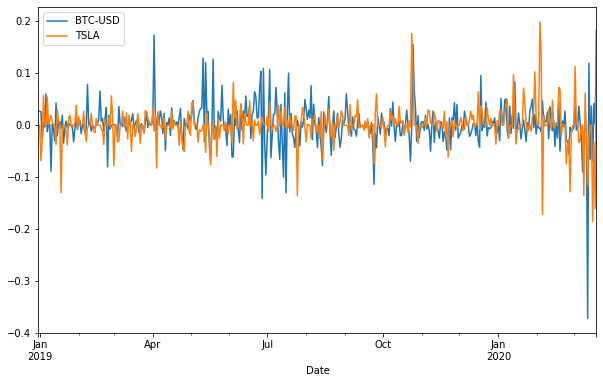

In [38]:
df_returns = df_financial.pct_change()
df_returns.plot(figsize = (10,6))

## Data processing

In [35]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("csv/articles_Bitcoin-Cryptocurrency_start=2019-01-01_end=2020-12-31.csv", index_col = 0)

def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [148]:
split_text = df.maintext.apply(get_split)
split_text.index = pd.DatetimeIndex(df["date_google"])

In [113]:
labels_list = []
dates = []
for date, arrays in split_text.itertuples():
    dates.extend([date]* len(arrays))
for date in dates:
    labels_list.append(df_returns["BTC-USD"].loc[date])

In [141]:
split_text_flat = split_text.values.flatten()
sentence_list = [sentence for array in split_text_flat for sentence in array]

labels = pd.DataFrame(labels_list, index = dates)
sentences  = pd.DataFrame(sentence_list, index = dates) 


In [139]:
len(sentences)

7649

In [159]:
# proporcion  2020-01-01 test
1288/7649.0

0.16838802457837626

In [149]:
sentences.head()

,0
2019-01-01,Cryptocurrency exchange HitBTC has frozen its ...
2019-01-01,withdrawal rejects at the behest of HitBTC. Ex...
2019-01-01,funds deposited with a third party service on ...
2019-01-01,Abkhazia Temporarily Shuts Down 15 Mining Farm...
2019-01-01,"Abkhazian authorities explained the measure, w..."


In [168]:
threshold = "2020-01-01"
train_sentences = sentences.loc[:"2019-12-31"]
test_sentences = sentences.loc["2020-01-01":]
train_labels = labels.loc[:"2019-12-31"]
test_labels = labels.loc["2020-01-01":]



In [170]:
from sklearn.model_selection import train_test_split

#train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size = 0.168)

## BERT 

In [6]:
BERT_URL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'
#module = hub.Module(BERT_URL)

'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'

In [188]:
bert_layer = hub.KerasLayer(BERT_URL,
 trainable=False)

In [8]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()


In [11]:
def create_tokenizer(vocab_file='vocab.txt', do_lower_case=False):
    return bert.bert_tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)


In [12]:
tokenizer = create_tokenizer(vocab_file)


In [150]:
def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    #Zero Mask till seq_length
    zero_mask = [0] * (max_seq_len-len(tokens))
    input_ids.extend(zero_mask)
    input_mask.extend(zero_mask)
    segment_ids.extend(zero_mask)
    
    return input_ids, input_mask, segment_ids

def convert_sentences_to_features(sentences, tokenizer, max_seq_len=200):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    
    for sentence in sentences:
        input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
        all_input_ids.append(input_ids)
        all_input_mask.append(input_mask)
        all_segment_ids.append(segment_ids)
    
    return all_input_ids, all_input_mask, all_segment_ids

In [151]:
max_seq_length = 200
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
 name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
 name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
 name="segment_ids")

bert_inputs = [input_word_ids, input_mask, segment_ids]

bert_outputs = bert_layer(bert_inputs)

In [29]:
#model = Model(inputs= bert_inputs, outputs=bert_outputs)

In [30]:

%%time
sentences = ['New Delhi is the capital of India', 'The capital of India is Delhi']
input_ids_vals, input_mask_vals, segment_ids_vals = convert_sentences_to_features(sentences, tokenizer, 200)
tokens = [input_ids_vals, input_mask_vals, segment_ids_vals]
output = model.predict(tokens)
#out = sess.run(bert_outputs, feed_dict={input_ids: input_ids_vals, input_mask: input_mask_vals, segment_ids: segment_ids_vals})

CPU times: user 1.81 s, sys: 263 ms, total: 2.07 s
Wall time: 1.67 s


In [33]:
output[0].shape

(2, 768)

In [184]:
train_input_ids, train_input_masks, train_segment_ids = convert_sentences_to_features(train_sentences.values.flatten(), tokenizer, 200)
test_input_ids, test_input_masks, test_segment_ids = convert_sentences_to_features(test_sentences.values.flatten(), tokenizer, 200)


In [250]:
def build_model(max_seq_length):
    # Build model
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    #bert_inputs = {"input_word_ids" : in_id, "input_mask" : in_mask, "input_type_ids" : in_segment}



    # Instantiate the custom Bert Layer defined above
    pooled_output, sequence_output  = bert_layer(inputs = bert_inputs)
    # Build the rest of the classifier 
    dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(pooled_output)
    #dense = tf.keras.layers.Dense(200, activation='sigmoid')(dense)
    pred = tf.keras.layers.Dense(1, activation='sigmoid', name = "output")(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [256]:
train_inputs = {
     "input_ids": np.array(train_input_ids),
     "input_mask": np.array(train_input_masks),
     "segment_ids": np.array(train_segment_ids),
     }
test_inputs = {
     "input_ids": np.array(test_input_ids, dtype = 'int64'),
     "input_mask": np.array(test_input_masks, dtype = 'int64'),
     "segment_ids": np.array(test_segment_ids, dtype = 'int64'),
     }
tr_labels = {
    "output" : train_labels.values.reshape(-1)
}
ts_labels = {
    "output" : test_labels.values.reshape(-1)
}

In [265]:
for k in test_inputs:
    test_inputs[k] = tf.cast(test_inputs[k], tf.int32)

In [246]:
 tf.int32

tf.int32

In [227]:
np.array(train_input_ids).shape

(6361, 200)

In [222]:
type(test_labels.values.tolist()[0])

list

In [230]:
train_labels.values.reshape(-1)

array([ 0.02693766,  0.02693766,  0.02693766, ..., -0.01362897,
       -0.01362897, -0.01362897])

In [236]:
history = model.fit(x = train_inputs, 
    y = tr_labels,
    validation_data=(test_inputs, ts_labels),
    epochs=1,
    batch_size=32
)

Train on 6361 samples, validate on 1288 samples
6361/6361 [==============================] - 20272s 3s/sample - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00


In [238]:
model.save("one_epoch_bert.hdf5")

In [258]:
test_model = build_model(max_seq_length)
test_model.load_weights('one_epoch_bert.hdf5')

In [260]:
predictions = test_model.evaluate(test_inputs, ts_labels)

1288/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [261]:
predictions

[0.002772992409574828, 0.0]

In [266]:
predictions = model.predict(test_inputs, batch_size=32)

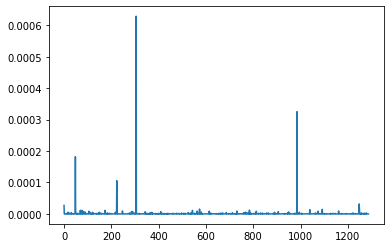

In [268]:
plt.plot(predictions.flatten())

In [272]:
predictions.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [271]:
min(predictions)

array([0.], dtype=float32)

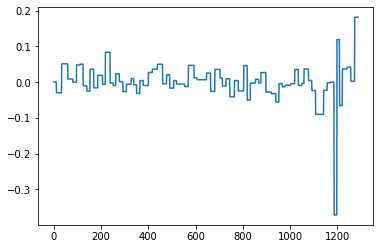

In [270]:
plt.plot(ts_labels["output"])